## Goals of this script: ## 

• Plot drive cycle (velocity over time) by route  

• Obtain total distance traveled along route, accounting for elevation change\

• Plot route on OpenStreetMap

--> Estimate the energy requirement for traveling along the route
    • the metadata will come in different csv's for each minibus, so adapt Fili's code to loop through the files and read them all in, and then for loop thru each for calculations.
---------------------------------------------------------------------------------------------------------

TO-DO:

Look at SUMO output and see what kind of output I want. Think about what we want in the paper and add those things

**Acceleration calculations** How to use XYZ accelerometer to calculate acceleration. Currently using dv/dt (Acceleration2 in drivecycle class)

**Map the routes** use folium?

**Implement 'drive cycle aggregator' function** Create aggregate drive cycle for certain type of route. 
Process: Identify route 'type', so as to group dataframes by that type
Identify time period across which to see a drive cycle
Take average velocities across this time period
Plot

In [4]:
import pandas as pd
import os
import numpy as np
import geopy.distance
import datetime
import geopandas
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import folium

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

## Main

Processing journey: KMDI - STB
Total estimated energy consumption for this route: 1.27 kWh
Total journey time: 7.75 minutes
Total journey distance: 2.71 km
Estimated vehicle efficiency: 0.4703 kWh/km
% of battery charge left: 98.73 %


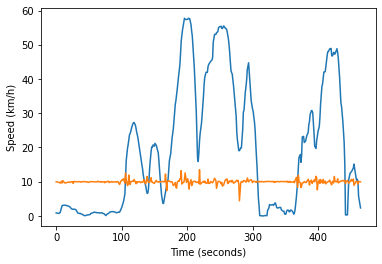

Processing journey: SW - STB
Total estimated energy consumption for this route: 16.15 kWh
Total journey time: 27.28 minutes
Total journey distance: 20.29 km
Estimated vehicle efficiency: 0.7958 kWh/km
% of battery charge left: 83.85 %


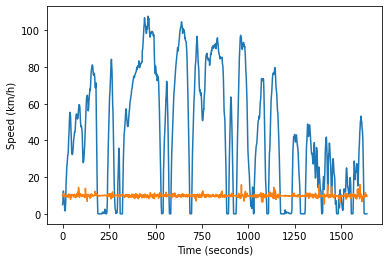

Processing journey: STB - KMDI
Total estimated energy consumption for this route: 4.26 kWh
Total journey time: 20.38 minutes
Total journey distance: 5.26 km
Estimated vehicle efficiency: 0.8111 kWh/km
% of battery charge left: 95.74 %


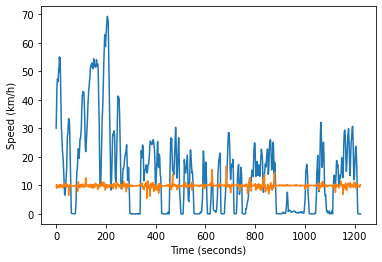

Processing journey: STB - SW
Total estimated energy consumption for this route: 16.62 kWh
Total journey time: 40.92 minutes
Total journey distance: 20.33 km
Estimated vehicle efficiency: 0.8177 kWh/km
% of battery charge left: 83.38 %


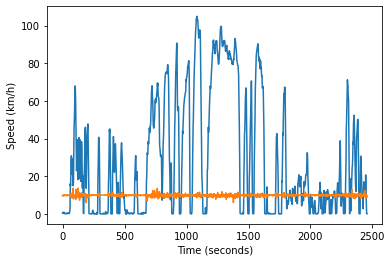

In [276]:
path = "./Data/"
raw_journeys = {} # Dictionary to hold raw journey data
processed_journeys = {} # Dictionary to hold processed data

#Read files into raw journeys dictionary
for filename in os.listdir(path):
    if filename.endswith('.CSV'):
        route = os.path.splitext(filename)[0]
        raw_journeys[route] = read_file(filename, path)

for key,val in raw_journeys.items():
    print("Processing journey:", key)
    journey = val
    
    getDistSlope(journey) # Augment journey dataframe with distance and slope columns
    minibus = Vehicle() # Instantiate vehicle object
    drvcycle = Drivecycle(journey) # Create drivecycle object with trip data
    
    # Compute energy expenditure (with and without regenerative braking)
    journey['Energy_WH'] = minibus.getEnergyExpenditure(drvcycle, regbrake = False)
    journey['Energy_RG_WH'] = minibus.getEnergyExpenditure(drvcycle)
    
    # Compute change in SoC at each timestep
    journey['SoC_RG'] = np.array(journey['Energy_RG_WH'])/minibus.capacity/3.6e6 

    # Journey statistics
    print("Total estimated energy consumption for this route:", round(journey.Energy_RG_WH.sum()/3.6e6,2), "kWh")
    print("Total journey time:", round(journey.RelTime.max()/60,2), "minutes")
    print("Total journey distance:", round(journey.Distance_3D_km.sum(),2), "km")
    print("Estimated vehicle efficiency:", round((journey.Energy_RG_WH.sum()/3.6e6)/journey.Distance_3D_km.sum(),4), "kWh/km")
    print("% of battery charge left:", round(100*(1 - journey.SoC_RG.sum()),2), "%")
    
    #Plot drive cycle
    fig = plt.figure()
    plt.plot(journey['RelTime'], journey['Speed'])
    plt.plot(journey['RelTime'], journey['Acceleration'])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Speed (km/h)")
    plt.show()
    
    #Keep track of processed journey dataframes
    processed_journeys[key] = journey

In [273]:
debug_df = processed_journeys['SW - STB']
# list(zip(debug_df['Acceleration'], debug_df['Acceleration_2']))
#list(zip(debug_df['Speed'], debug_df['Acceleration']))

debug_df['SoC_RG'].sum() 

0.16146103000055045

In [250]:
# v = debug_df['Speed']
# s = debug_df['slope_rad']
# a = debug_df['Acceleration_2']
# dt = debug_df['DeltaT']
# mass = 2900
# crr = 0.01
# A = 4
# cd = 0.5
# Fr = []
# Pr = []
# Er = []
# fi = []
# fr = []
# fa = []
# fs = []
# for slope,vel,acc,delta_time in zip(s,v,a,dt):
#         fi.append(round(getInertialForce(mass, acc),2))
#         fr.append(round(getRoadFriction(mass,crr, slope),2))
#         fa.append(round(getAerodynamicDrag(cd, A, vel),2))
#         fs.append(round(getRoadSlopeDrag(mass, slope),2))
#         force = getInertialForce(mass, acc) + \
#                 getRoadFriction(mass,crr, slope) + \
#                 getAerodynamicDrag(cd, A, vel) + \
#                 getRoadSlopeDrag(mass, slope)
#         power = force * vel #W
#         energy = power * delta_time  # Ws
#         Fr.append(force) # N
#         Pr.append(power) # W
#         Er.append(energy/3.6e3/1e3) # kWh
        
#         # Take into account efficiency of vehicle propulsion, and regenerative braking


# #plt.scatter(a,Er)
# # observations: never negative. the two distinct lines are from dt = 1 or dt = 2
# # acceleration clusters highest energy requirement around 0, with normal distribution. why is that???

In [254]:
''' 
Takes in name of csv file with vehicle journey data
Returns augmented dataframe ready for analysis

TODO: Take out acceleration sanity check when no longer needed
'''
def read_file(filename, path):
    journey = pd.read_csv(path + filename)
   
    # Join date and time columns into one column, and drop individual columns
    journey['DateTime'] = pd.to_datetime(journey['Date'] + journey['Time'], format = '%m/%d/%Y%H:%M:%S')
    
    # Calculate acceleration from x,y,z-axis accelerations
    journey['X-Axis Acceleration m/s^2'] = 9.80665 * journey['X-Axis Acceleration']
    journey['Y-Axis Acceleration m/s^2'] = 9.80665 * journey['Y-Axis Acceleration']
    journey['Z-Axis Acceleration m/s^2'] = 9.80665  * journey['Z-Axis Acceleration']
    journey['Acceleration'] = np.sqrt(journey['X-Axis Acceleration m/s^2']**2 + journey['Y-Axis Acceleration m/s^2']**2 + journey['Z-Axis Acceleration m/s^2']**2)

    # Calculate time elapsed between each timestamp
    journey['DeltaT'] = journey['DateTime'] - journey['DateTime'].shift(1) 
    journey.DeltaT = journey['DeltaT'] / np.timedelta64(1, 's') # Convert from timedelta to int
    
    # Sanity check on acceleration using dV/dT

    journey['DeltaV'] = journey['Speed'] - journey['Speed'].shift(1) 
    journey['Acceleration_2'] = journey['DeltaV']/journey['DeltaT']

    
    # Relative time from start of journey, used for plotting drive cycle
    journey["RelTime"] = journey["DateTime"] - journey["DateTime"].min() 
    journey.RelTime = journey['RelTime'] / np.timedelta64(1, 's') # Convert from timedelta to int
        
    # Elevation change between each recording
    journey['ElevChange'] = journey['Altitude'] - journey["Altitude"].shift(1) # Ma y not be needed if don't use haversine function 
   
    # Joins Lat/Lon Coords into one column, useful for getDist function
    journey['Coordinates'] = list(zip(journey.Latitude, journey.Longitude)) 

    return journey

In [255]:
''' 
Inputs: dataframe with vehicle journey data

Calculates distance between each successive pair of lat/lon coordinates
(accounts for elevation difference)

Calculates slope angle faced by vehicle at each timestamp

TODO: decide arcsin or arccos approach. which is more accurate?

'''
def getDistSlope(journey):
    Distance = np.zeros(len(journey))
    Slope = np.zeros(len(journey))
    Slope_tan = np.zeros(len(journey))
    l_route = journey.shape[0]

    for i in range(1,l_route):
        elev_change = journey.Altitude.iloc[i]-journey.Altitude.iloc[i-1]
        dist_lateral = geopy.distance.geodesic(journey.Coordinates.iloc[i-1],  # Lateral distance in meters - dist between two lat/lon coord pairs
                                       journey.Coordinates.iloc[i]).m
        dist_3d = np.sqrt(dist_lateral**2 + elev_change**2)  # 3d dist -- accounting for elevation
        Distance[i] = dist_3d/1e3 # convert to km
        if Distance[i] != 0:
           # Slope[i] = np.arccos(dist_lateral/dist_3d) # Would rather use arcsin since that uses 1 measured value instead of 2 calculated values, but that doesn't work
            Slope[i] = np.arcsin(elev_change/dist_3d)
    journey['Distance_3D_km'] = list(Distance)
    journey['slope_rad'] = list(Slope) 

## Energy Requirements Analysis 
To-Do: implement vehicle parameters, get estimated energy consumption for a route. Get SoC along route

In [256]:
# Functions that calculate four different types of forces acting on the vehicle, used in calculating total road load 
# based on functions shown here https://x-engineer.org/ev-design-energy-consumption/\

# Inertial Force
def getInertialForce(mass, accel):
    return mass * accel

# Road load (friction)
def getRoadFriction(mass, c_rr, slope, grav = 9.81): #c_rr is coeff of rolling resistance
    return mass * grav * c_rr * np.cos(slope)

# Aerodynamic Drag Force
def getAerodynamicDrag(c_d, A, vel, rho = 1.204): # rho is air density 20C, c_d is air drag coeff
    return 0.5 * rho * c_d * A * vel**2

# Road Slope Force
def getRoadSlopeDrag(mass, slope, grav = 9.81):
    return mass * grav * np.sin(slope)

In [269]:
class Vehicle:
    """
    Inputs: Physical parameters of vehicle for modeling energy consumption
    Returns an array of vehicle energy consumption at each timestamp
    
    mass - vehicle mass (kg)
    cd - coefficient of drag
    crr - coefficient of rolling resistance
    A - vehicle frontal area (m^2)
    eff - vehicle propulsion efficiency
    rgbeff - regenerative braking energy recuperation efficiency 
    cap - vehicle battery cap (kWh)
    p0 - constant power intake (W)
    """
    
    def __init__(self, mass = 2900, 
                 cd = 0.368, crr = 0.01, A = 4,
                 eff = 0.8, rgbeff = 0.5, cap = 100, p0 = 100):

        # Vehicle physical parameters
        self.mass = mass # kg
        self.load = 0.0 #kg
        self.crr = crr # coefficient of rolling resistance
        self.cd = cd  # air drag coefficient
        self.A = 4 # m^2, Approximation of vehicle frontal area 
        self.eff = eff
        self.rgbeff = rgbeff 
        self.capacity = cap 
        self.battery = cap
        self.p0 = p0 # constant power loss in W (to run the vehicle besides driving)
        
    def getEnergyExpenditure(self,cycle,regbrake = True):
        # computes energy expenditure from a Drivecycle object
        # dt default 1 second
        
        v = cycle.velocity/3.6 # m/s 
        s = cycle.slope # rad
        a = cycle.acceleration # m/s^2
        dt = cycle.dt # s
        d = cycle.displacement # m
        
        if regbrake == True:
            RGBeff = self.rgbeff
        else:
            RGBeff = 0
                        
        Fr = [] # Drag force: Inertia + Friction + Aero Drag + Slope Drag (N)
        Pr = [] # Total Power (W)
        Er = [] # Total energy consumption (J), from battery if positive, to battery if negative (RGbrake)
        for slope,vel,acc,delta_time in zip(s,v,a,dt):
            force = getInertialForce(self.mass, acc) + \
                    getRoadFriction(self.mass,self.crr, slope) + \
                    getAerodynamicDrag(self.cd, self.A, vel) + \
                    getRoadSlopeDrag(self.mass, slope)
            power = force * vel #W
            energy = power * delta_time  # Ws
            Fr.append(force) # N
            Pr.append(power) # W
            Er.append(energy) # Wh
            
        Em_eff = [0.0]*len(Er)
        for i in range(len(Er)):
            if Er[i] > 0:
                Em_eff[i] = Er[i]/self.eff
            elif Er[i] < 0:
                Em_eff[i]= Er[i]*RGBeff   

       # adds constant loss p0 (100W)
        for i in range(len(Em_eff)):
            if v[i] > 0.55: # [m/s] = 2.0 km/h to make sure that the vehicle is not parked (and engine maybe turned off)
                Em_eff[i] += self.p0
                
        # output in watt-hours
        return Em_eff

In [267]:
class Drivecycle: 
    """
    Inputs: dataframe with journey info
    """
    def __init__(self, journey): 
        self.displacement = journey.Distance_3D_km # m
        self.velocity = journey.Speed # km/h - make sure to convert to m/s before using in calcs
        self.acceleration = journey.Acceleration_2 # m/s^2
        self.slope = journey.slope_rad # rad
        self.time = journey.RelTime.max() # Total Time Elapsed
        self.dt = journey.DeltaT # Time elapsed between each timestamp
        
        
        

In [280]:
# Plotting route on Folium
for filename, journey in processed_journeys.items():
    map1 = folium.Map(
        location=[journey["Latitude"][1], journey["Longitude"][1]],
        tiles='cartodbpositron',
        zoom_start=12,
    )
    journey.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
    map1

In [281]:
map1 = folium.Map(
        location=[debug_df["Latitude"][1], debug_df["Longitude"][1]],
        tiles='cartodbpositron',
        zoom_start=12,
    )
debug_df.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
map1

## Extra processing if needed, to use in the EV Fleet Simulator

In [244]:
newdf.to_csv("ev-fleet-sim-master/src/test_johan/_Inputs/Traces/Processed/test_johan.csv")

In [ ]:
newdf["Time"] = newdf["DateTime"]
newdf = newdf.drop(labels = ["DateTime"], axis = 1)

In [242]:
newdf["GPSID"] = newdf.index
newdf

,Latitude,Longitude,Altitude,Heading,X-Axis Acceleration,Y-Axis Acceleration,Z-Axis Acceleration,Velocity,Time,GPSID
0,-33.93113,18.85856,119.0,329.52,0.020,0.188,1.028,0.46,2022-03-10 15:08:51,0
1,-33.93113,18.85856,119.2,329.52,0.054,0.156,1.062,0.52,2022-03-10 15:08:53,1
2,-33.93113,18.85856,119.5,329.52,0.052,0.174,1.026,0.61,2022-03-10 15:08:55,2
3,-33.93113,18.85855,119.6,329.52,0.008,0.160,0.964,0.35,2022-03-10 15:08:56,3
4,-33.93113,18.85855,119.7,329.52,0.052,0.072,1.056,0.30,2022-03-10 15:08:57,4
...,...,...,...,...,...,...,...,...,...,...
613,-33.96375,18.84001,128.2,59.04,-0.076,0.160,0.952,7.07,2022-03-10 15:23:34,613
614,-33.96373,18.84003,128.1,35.08,0.028,0.142,1.024,0.26,2022-03-10 15:23:36,614
615,-33.96373,18.84003,127.9,35.08,0.104,0.116,0.960,0.09,2022-03-10 15:23:37,615
616,-33.96373,18.84003,128.8,35.08,0.112,0.156,0.994,0.07,2022-03-10 15:23:39,616
